In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras.models import load_model,Model
import random
import math
import threading
import time

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
import copy
x_tmp = copy.deepcopy(x_test[0])

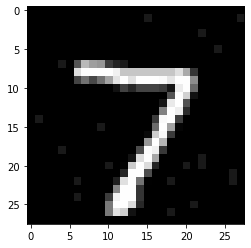

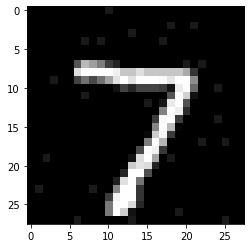

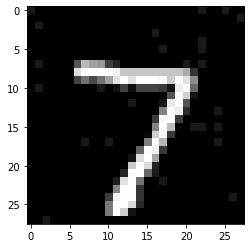

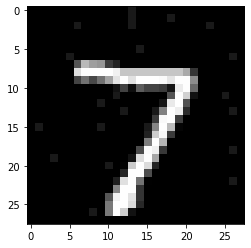

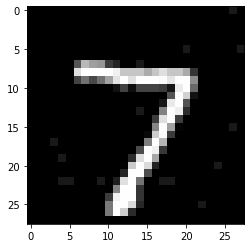

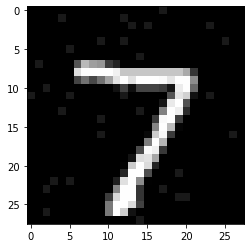

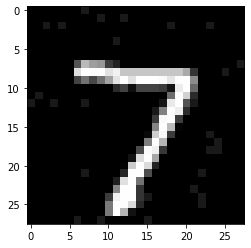

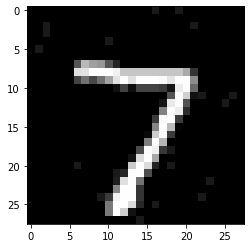

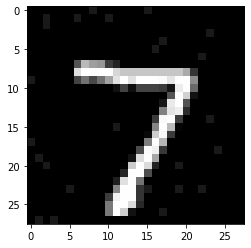

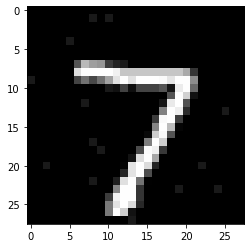

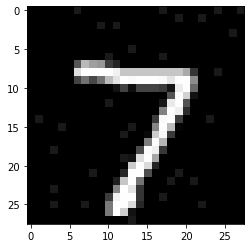

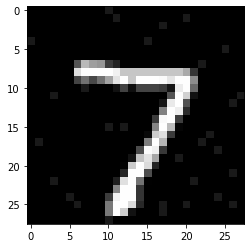

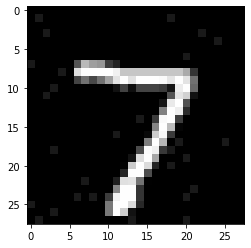

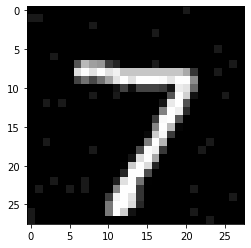

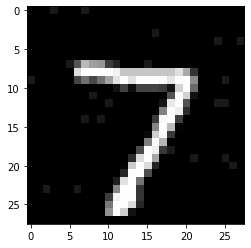

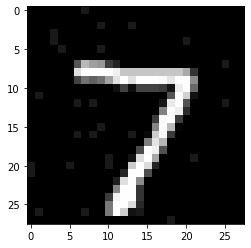

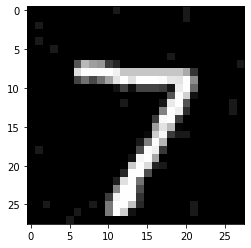

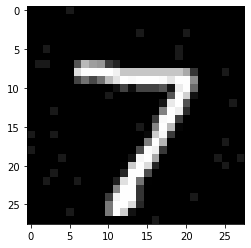

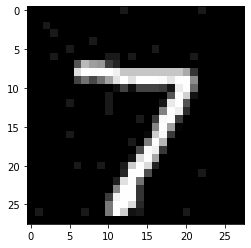

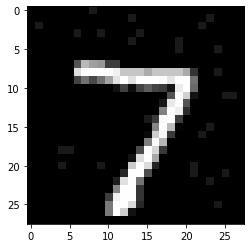

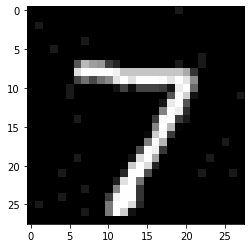

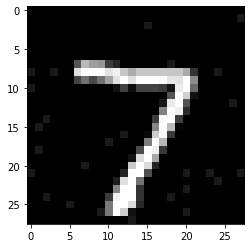

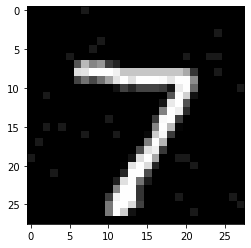

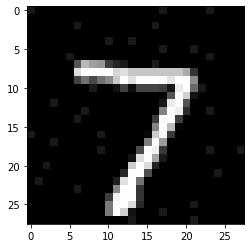

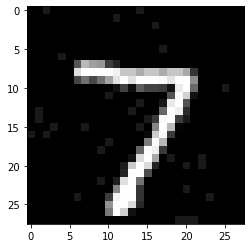

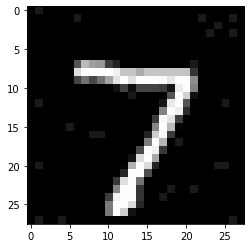

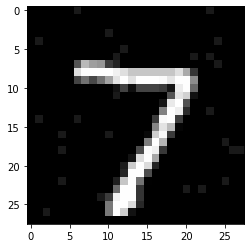

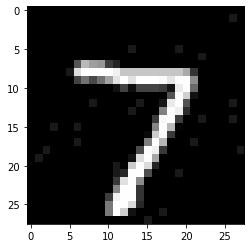

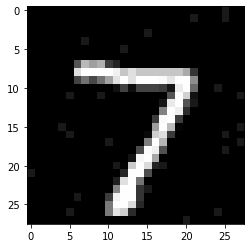

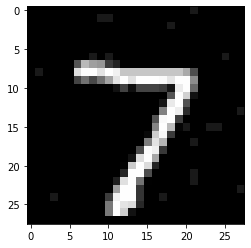

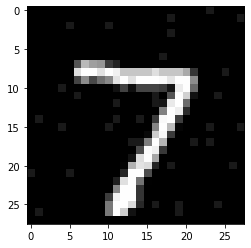

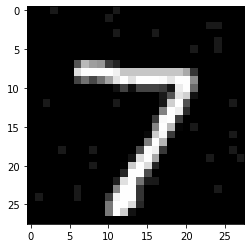

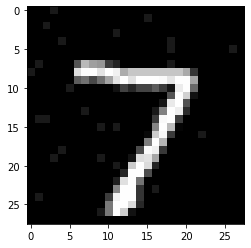

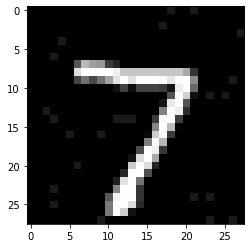

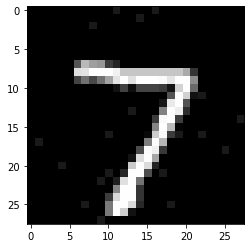

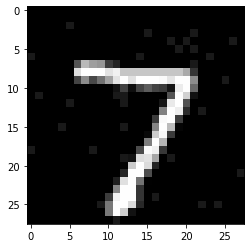

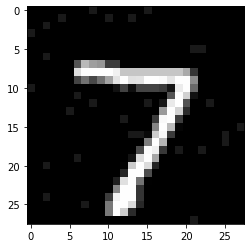

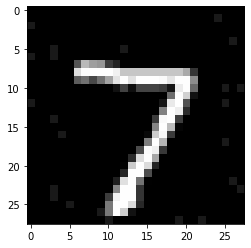

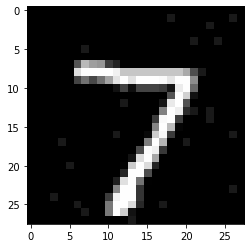

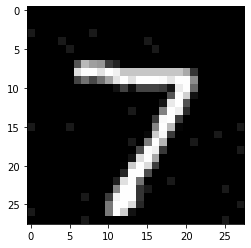

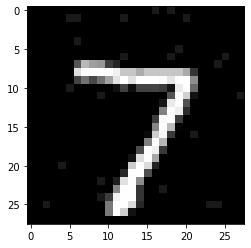

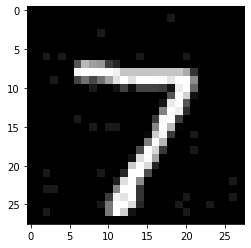

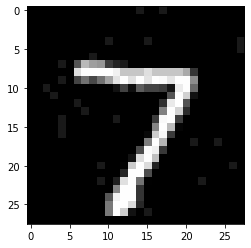

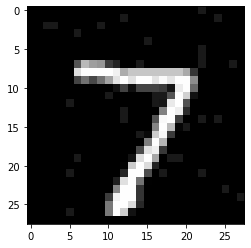

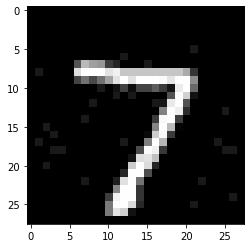

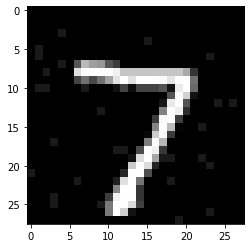

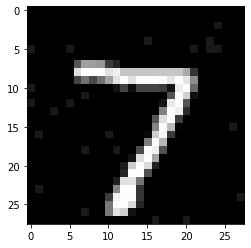

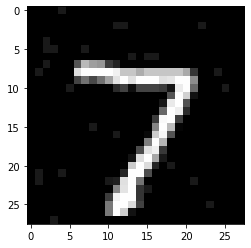

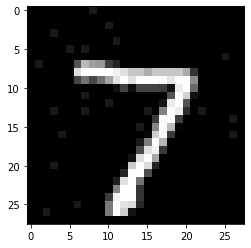

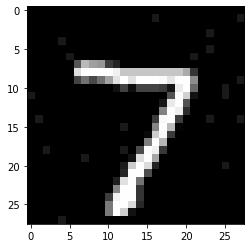

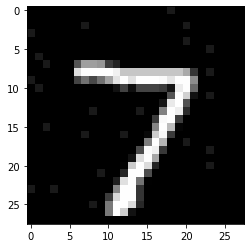

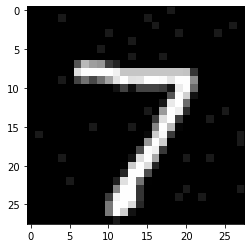

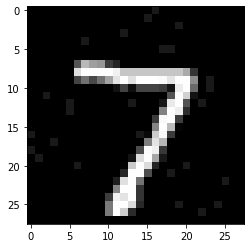

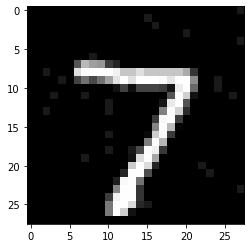

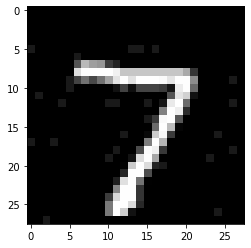

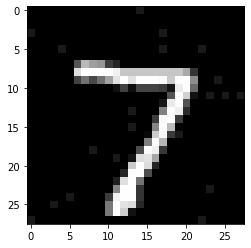

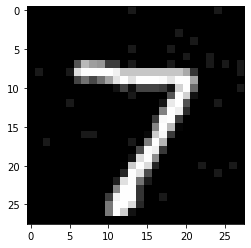

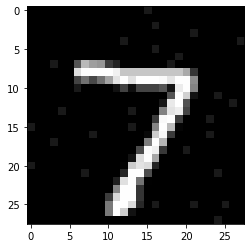

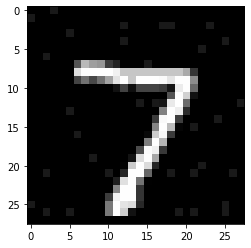

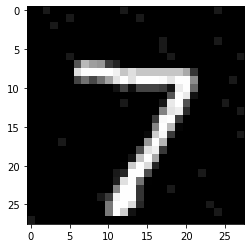

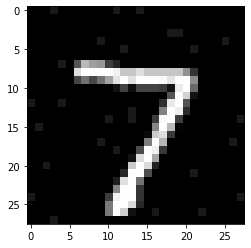

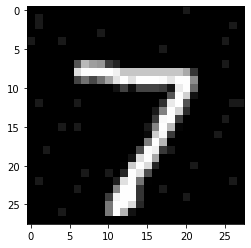

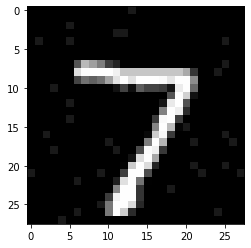

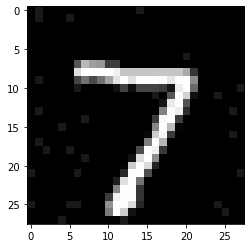

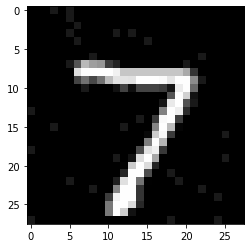

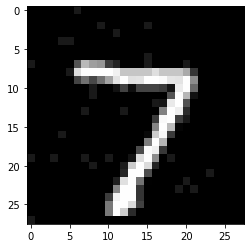

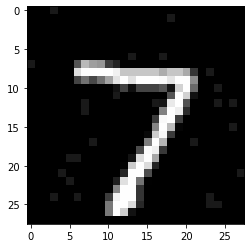

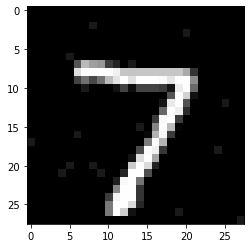

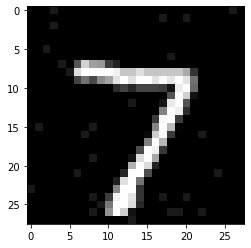

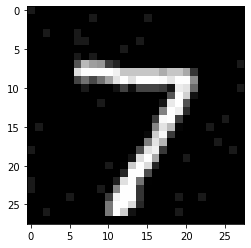

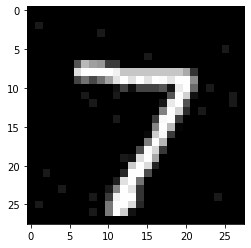

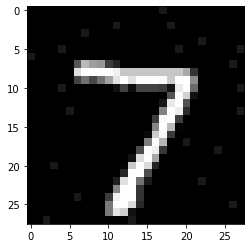

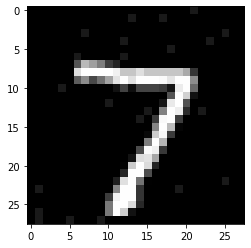

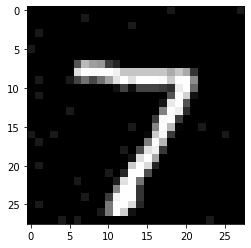

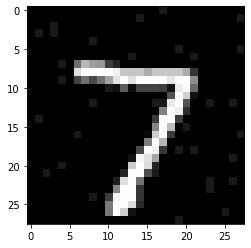

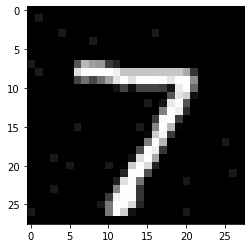

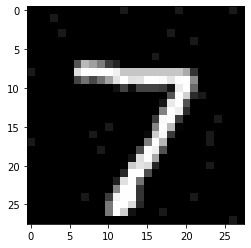

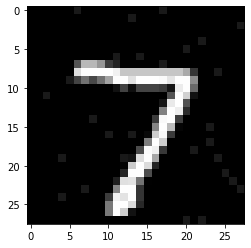

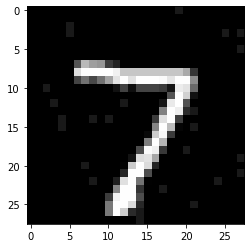

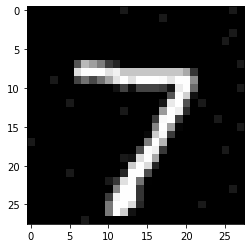

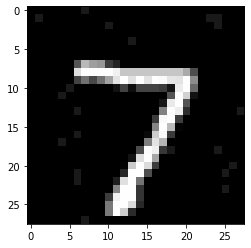

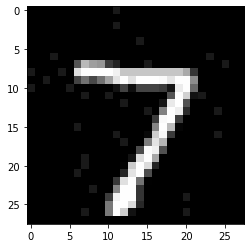

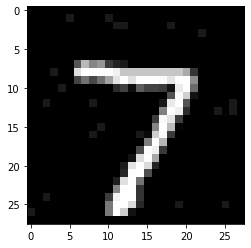

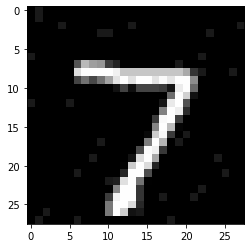

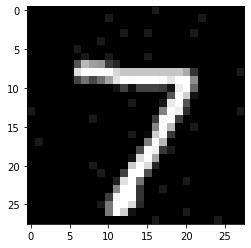

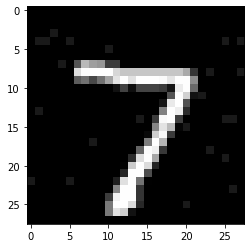

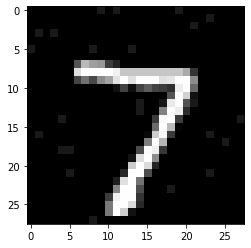

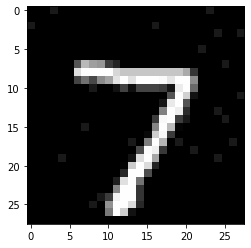

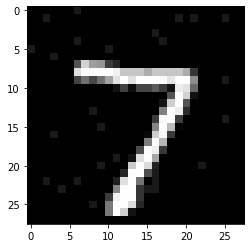

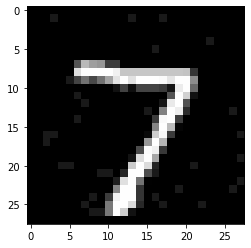

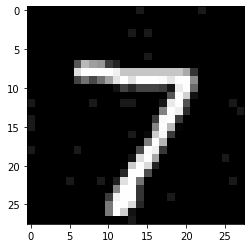

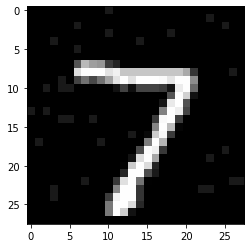

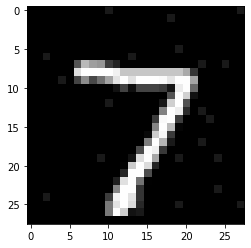

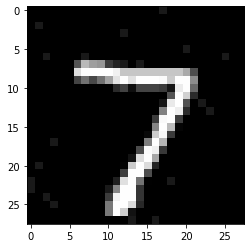

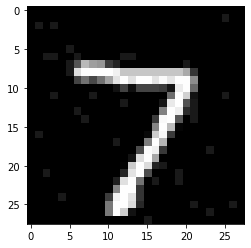

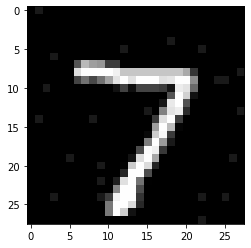

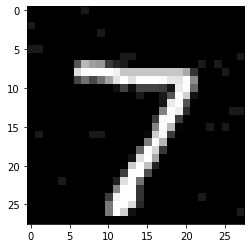

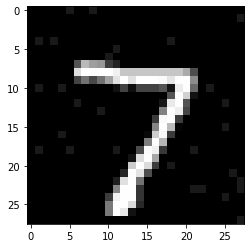

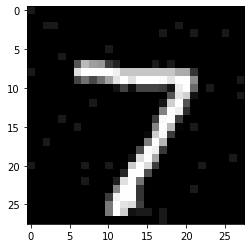

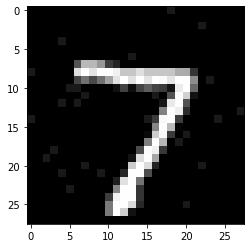

In [4]:
#产生扰动种群
x_des = []
for r in range(100):
    for i in range(28):
        for j in range(28):
            x= random.randint(0,10000)/10000
            if x <= 0.1:
                u = x_tmp[i,j] # 期望值μ
                sig = math.sqrt(0.2) # 标准差δ
                x_ = random.uniform(u - 3*sig, u + 3*sig)
                y_sig = np.exp(-(x_ - u) ** 2 /(2* sig **2))/(math.sqrt(2*math.pi)*sig)
                y_= random.randint(0,10000)/10000
                if y_ <= y_sig:
                    if x_test[0][i,j] <= 127:
                        x_tmp[i,j] += 255*0.1
                    elif x_test[0][i,j] > 127 and x_test[0][i,j] < 229:
                        y = random.randint(0,10000)/10000
                        if y <= 0.5:
                            x_tmp[i,j] += 255*0.1
                        else:
                            x_tmp[i,j] -= 255*0.1
                    elif x_test[0][i,j] >= 229:
                        x_tmp[i,j] -= 255*0.1
    x_t = x_tmp/255-x_test[0]/255
    #x_des.append(np.array (x_t.reshape(1,784)))
    x_des.append(np.array(x_t.reshape(1,784)))
    plt.imshow(x_tmp,cmap='gray')
    plt.show()
    x_tmp = copy.deepcopy(x_test[0])

In [4]:
x_train = x_train.reshape(60000,784)    # 将图片摊平，变成向量

In [5]:
x_test = x_test.reshape(10000,784)     # 对测试集进行同样的处理

In [6]:
x_train = x_train / 255
x_test = x_test / 255 

In [7]:
model = load_model('mnist_model.h5')

In [8]:
def Func(x):
    x_F = x[:]+x_test[0]
    result=model.predict(x_F.reshape(1,784))
    return result[0][7]

In [9]:
def Dis(x):   # 扰动值
    res = 0
    for i in range(784):
        l = x[i]
        res += l**2
    return res

In [11]:
# 攻击模块
class Atk(threading.Thread):

    def __init__(self,cond,name):
        #threading.Thread.__init__(self)
        super(Atk, self).__init__()
        self.cond = cond
        self.name = name

    def run(self):
        self.cond.acquire()
        print(self.name)
        global F
        global D
        global BEST_X
        global GENERATION
        #global best
        while GENERATION < MAX_GENERATION:
        #while Func(BEST_X) >= 0.35 or Dis(BEST_X) >= 6.5:
        #for t in range(5):
            #print(Func(BEST_X))
            DB = Dis(BEST_X)    # 存储上一代的扰动程度
            Db[:] = best[:]
            s = 1
            
            # 变异
            for i in range(N):
                r = np.random.randint(1, N, 2)
                V[i, :] = BEST_X + SIGMA * (X[r[0], :] - X[r[1], :])
                for j in range(784):
                    if V[i, j] > 1:
                        #print(V[i, j])
                        V[i, j] = 1-(V[i, j]-1)
                        #print(V[i, j])
                    elif V[i, j] <= 1:
                        if V[i, j] + x_test[0][j] > 1:
                            # V +t = 1-(V+t-1)
                            V[i, j] = 1-(V[i, j]+2*x_test[0][j]-1)
                            #print(V[i, j])
                        elif V[i, j] + x_test[0][j] < 0:
                            V[i, j] = -x_test[0][j]
            # print(V)
            # 交叉操作
            for i in range(N):
                jRand = np.floor(np.random.random() * L)
                for j in range(L):
                    # 至少有一个分量对U[i,j]作出了贡献
                    # CR调小 有利于往BEST_X的方向进化
                    if np.random.random() > CR or j == jRand:
                        U[i, j] = X[i, j]
                    else:
                        U[i, j] = V[i, j]
                    #if np.random.random() < CR or j == jRand:
                        #U[i, j] = V[i, j]
                    #else:
                        #U[i, j] = X[i, j]
            # 计算适应度值+选择操作
            for i in range(N):
                FITS[i] = Func(X[i])
                FITS_U[i] = Func(U[i])
                DIS[i] = Dis(X[i])
                DIS_U[i] = Dis(U[i])
                
                D_ = DIS_U[i] - DB
                # 变异的种子表现更好
                if FITS[i] >= FITS_U[i] and D_ < 0.1:
                    X[i, :] = U[i, :]
                    FITS[i] = FITS_U[i]
                    if FITS_U[i] < Func(BEST_X) and D_ < 0.1:
                        BEST_X = U[i, :]
            GENERATION += 1
            
            print("最优值：", Func(BEST_X),"扰动程度：",Dis(BEST_X),"代数：",GENERATION)
            #print("Db ","最优值：", Func(Db),"扰动程度：",Dis(Db))
            best[:] = Db[:]
            if Func(best) > 0.45:
                s -= 1     # 触发（检测此步骤是否有执行）
                best[:] = BEST_X[:]
                print("best ","最优值：", Func(best),"扰动程度：",Dis(best))
            if s == 1:
                best[:] = Db[:]
            
            if Func(BEST_X) <= 0.45:
                if Func(BEST_X) < Func(best) and Dis(BEST_X) < Dis(best):   # 保存最好的数值
                    s -= 1     # 触发（检测此步骤是否有执行）
                    #print("test-B","最优值：", Func(BEST_X),"扰动程度：",Dis(BEST_X))
                    #print("test-b","最优值：", Func(best),"扰动程度：",Dis(best))
                    best[:] = BEST_X[:]
                    print("best ","最优值：", Func(best),"扰动程度：",Dis(best))
            print(" ")        
            if s == 1:
                best[:] = Db[:]
            
            if Func(BEST_X) <= F:
                print("resume")
                if D < 6.5:
                    D += 0.4 
                self.cond.notify()  # 唤醒一个挂起的线程
                self.cond.wait()
        self.cond.release()


# 恢复模块
class Re(threading.Thread):

    def __init__(self,cond,name):
        #threading.Thread.__init__(self)
        super(Re, self).__init__()
        self.cond = cond
        self.name = name

    def run(self):
        #time.sleep(1)
        self.cond.acquire()
        self.cond.wait()
        #print(self.name)
        global F
        global D
        global BEST_X
        global GENERATION
        #global best
        while GENERATION < MAX_GENERATION:
        #while Func(BEST_X) >= 0.35 or Dis(BEST_X) >= 6.5:
        #for t in range(5):
            #print(Func(BEST_X))
            FB = Func(BEST_X)    # 存储上一代的置信度
            Fb[:] = best[:]
            s = 1
            
            # 变异
            for i in range(N):
                r = np.random.randint(1, N, 2)
                V[i, :] = BEST_X + SIGMA * (X[r[0], :] - X[r[1], :])
                for j in range(784):
                    if V[i, j] > 1:
                        #print(V[i, j])
                        V[i, j] = 1-(V[i, j]-1)
                        #print(V[i, j])
                    elif V[i, j] <= 1:
                        if V[i, j] + x_test[0][j] > 1:
                            # V +t = 1-(V+t-1)
                            V[i, j] = 1-(V[i, j]+2*x_test[0][j]-1)
                            #print(V[i, j])
                        elif V[i, j] + x_test[0][j] < 0:
                            V[i, j] = -x_test[0][j]
            # print(V)
            # 交叉操作
            for i in range(N):
                jRand = np.floor(np.random.random() * L)
                for j in range(L):
                    # 至少有一个分量对U[i,j]作出了贡献
                    # CR调小 有利于往BEST_X的方向进化
                    if np.random.random() > CR or j == jRand:
                        U[i, j] = X[i, j]
                    else:
                        U[i, j] = V[i, j]
                    #if np.random.random() < CR or j == jRand:
                        #U[i, j] = V[i, j]
                    #else:
                        #U[i, j] = X[i, j]
            # 计算适应度值+选择操作
            for i in range(N):
                FITS[i] = Func(X[i])
                FITS_U[i] = Func(U[i])
                DIS[i] = Dis(X[i])
                DIS_U[i] = Dis(U[i]) 
                F_ = FITS_U[i] - FB
                
                # 变异的种子表现更好
                #if FITS[i] >= FITS_U[i] and DIS[i] >= DIS_U[i]:
                if DIS[i] >= DIS_U[i] and F_ < 0.01:
                    X[i, :] = U[i, :]
                    FITS[i] = FITS_U[i]
                    if DIS_U[i] < Dis(BEST_X) and F_ < 0.01:
                        BEST_X = U[i, :]
            GENERATION += 1
            #print(F_)
            print("最优值：", Func(BEST_X),"扰动程度：",Dis(BEST_X),"代数：",GENERATION)
            #print("Fb ","最优值：", Func(Fb),"扰动程度：",Dis(Fb))
            best[:] = Fb[:]
            if Func(best) > 0.45:
                s -= 1     # 触发（检测此步骤是否有执行）
                best[:] = BEST_X[:]
                print("best ","最优值：", Func(best),"扰动程度：",Dis(best))
            if s == 1:
                best[:] = Fb[:]
            
            if Func(BEST_X) <= 0.45:
                if Func(BEST_X) < Func(best) and Dis(BEST_X) < Dis(best):   # 保存最好的数值
                    s -= 1     # 触发（检测此步骤是否有执行）
                    #print("test-B","最优值：", Func(BEST_X),"扰动程度：",Dis(BEST_X))
                    #print("test-b","最优值：", Func(best),"扰动程度：",Dis(best))
                    best[:] = BEST_X[:]
                    print("best ","最优值：", Func(best),"扰动程度：",Dis(best))
            print(" ")         
            if s == 1:
                best[:] = Fb[:]
            
            if Dis(BEST_X) <= D:
                print("attack")
                if F > 0.3:
                    F -= 0.1
                self.cond.notify()
                self.cond.wait()
        self.cond.release()
        

In [12]:
MAX_GENERATION = 1000  # 最大迭代次数
GENERATION = 0  # 当前代数
L = 784  # 种子的维度
N = 100  # 种群规模
SIGMA = 0.333  # 缩放因子
CR = 0.1  # 交叉概率
F = 0.8   #置信度参数
D = 3.0   #扰动参数
cond = threading.Condition()
atk = Atk(cond, "attack")
re = Re(cond, "resume")
best = 0
GENERATION = 0  # 当前代数
BEST_X = 0
FITS = np.zeros(N)
FITS_U = np.zeros(N)
DIS = np.zeros(N)
DIS_U = np.zeros(N)
V = np.zeros((N, L))
U = np.zeros((N, L))
Db = np.zeros(L)
Fb = np.zeros(L)
# 1、初始化
X = np.concatenate(x_des, axis=0)
# 找出随机生成的最好的种子
for i in range(N):
    FITS[i] = Func(X[i])
# 找出最好的种子 适应度值最小
BEST_X = X[np.argmin(FITS)]
best = X[np.argmin(FITS)]
re.start()
atk.start()

#re.join()
#atk.join()
if Func(BEST_X) < 0.4:
    BEST_F = BEST_X+x_test[0]
    #print(BEST_X_F)
    plt.imshow(BEST_F.reshape(28,28),cmap='gray')
    plt.show()
    #break

attack
最优值： 0.9965784 扰动程度： 0.407077623990773 代数： 1
best  最优值： 0.9965945 扰动程度： 0.37720876585928514
 
最优值： 0.9963153 扰动程度： 0.3768113453510287 代数： 2
best  最优值： 0.9963153 扰动程度： 0.3768113453510287
 
最优值： 0.9961987 扰动程度： 0.47581857334026373 代数： 3
best  最优值： 0.9961987 扰动程度： 0.47581857334026373
 
最优值： 0.9961159 扰动程度： 0.5372856961363277 代数： 4
best  最优值： 0.9961159 扰动程度： 0.5372856961363277
 
最优值： 0.99612856 扰动程度： 0.5417899877547553 代数： 5
best  最优值： 0.99612856 扰动程度： 0.5417899877547553
 
最优值： 0.99608266 扰动程度： 0.3448892952637583 代数： 6
best  最优值： 0.99608266 扰动程度： 0.3448892952637583
 
最优值： 0.99592775 扰动程度： 0.41770109163450153 代数： 7
best  最优值： 0.99592775 扰动程度： 0.41770109163450153
 
最优值： 0.9958574 扰动程度： 0.4224468131368295 代数： 8
best  最优值： 0.9958574 扰动程度： 0.4224468131368295
 
最优值： 0.995626 扰动程度： 0.43118675252669403 代数： 9
best  最优值： 0.995626 扰动程度： 0.43118675252669403
 
最优值： 0.99560505 扰动程度： 0.43353667990971523 代数： 10
best  最优值： 0.99560505 扰动程度： 0.43353667990971523
 
最优值： 0.9953082 扰动程度： 0.471639106629013

最优值： 0.96615064 扰动程度： 2.1630454539415767 代数： 87
best  最优值： 0.96615064 扰动程度： 2.1630454539415767
 
最优值： 0.96485716 扰动程度： 2.234819642990451 代数： 88
best  最优值： 0.96485716 扰动程度： 2.234819642990451
 
最优值： 0.96474665 扰动程度： 2.2490242481186087 代数： 89
best  最优值： 0.96474665 扰动程度： 2.2490242481186087
 
最优值： 0.96427256 扰动程度： 2.2552730585836427 代数： 90
best  最优值： 0.96427256 扰动程度： 2.2552730585836427
 
最优值： 0.96358955 扰动程度： 2.1922669307069373 代数： 91
best  最优值： 0.96358955 扰动程度： 2.1922669307069373
 
最优值： 0.9636518 扰动程度： 2.2095807418641646 代数： 92
best  最优值： 0.9636518 扰动程度： 2.2095807418641646
 
最优值： 0.959774 扰动程度： 2.2558135658072684 代数： 93
best  最优值： 0.959774 扰动程度： 2.2558135658072684
 
最优值： 0.9590073 扰动程度： 2.2799151540840352 代数： 94
best  最优值： 0.9590073 扰动程度： 2.2799151540840352
 
最优值： 0.95888215 扰动程度： 2.294633924721991 代数： 95
best  最优值： 0.95888215 扰动程度： 2.294633924721991
 
最优值： 0.9584598 扰动程度： 2.3233474197059576 代数： 96
best  最优值： 0.9584598 扰动程度： 2.3233474197059576
 
最优值： 0.9578997 扰动程度： 2.3366678683674937 代数： 

最优值： 0.83530426 扰动程度： 4.050470651461323 代数： 173
best  最优值： 0.796775 扰动程度： 4.537279543190311
 
最优值： 0.84402066 扰动程度： 3.9326528264387175 代数： 174
best  最优值： 0.796775 扰动程度： 4.537279543190311
 
最优值： 0.849755 扰动程度： 3.919408135656466 代数： 175
best  最优值： 0.796775 扰动程度： 4.537279543190311
 
最优值： 0.8582006 扰动程度： 3.8547135350306903 代数： 176
best  最优值： 0.796775 扰动程度： 4.537279543190311
 
最优值： 0.8619665 扰动程度： 3.7682438720274436 代数： 177
best  最优值： 0.796775 扰动程度： 4.537279543190311
 
最优值： 0.86674917 扰动程度： 3.6466820341601274 代数： 178
best  最优值： 0.796775 扰动程度： 4.537279543190311
 
最优值： 0.8688538 扰动程度： 3.6029702786569033 代数： 179
best  最优值： 0.796775 扰动程度： 4.537279543190311
 
最优值： 0.8722214 扰动程度： 3.574897209647695 代数： 180
best  最优值： 0.796775 扰动程度： 4.537279543190311
 
最优值： 0.88210106 扰动程度： 3.545601489511467 代数： 181
best  最优值： 0.796775 扰动程度： 4.537279543190311
 
最优值： 0.88817614 扰动程度： 3.332367997341575 代数： 182
best  最优值： 0.796775 扰动程度： 4.537279543190311
 
attack
最优值： 0.8892202 扰动程度： 3.3290458121121334 代数： 183
best  

最优值： 0.75345945 扰动程度： 4.553780220673814 代数： 260
best  最优值： 0.69452333 扰动程度： 5.23707521812809
 
最优值： 0.7628076 扰动程度： 4.5005516017854434 代数： 261
best  最优值： 0.69452333 扰动程度： 5.23707521812809
 
最优值： 0.76449007 扰动程度： 4.457363394535532 代数： 262
best  最优值： 0.69452333 扰动程度： 5.23707521812809
 
最优值： 0.77446616 扰动程度： 4.3859754674652205 代数： 263
best  最优值： 0.69452333 扰动程度： 5.23707521812809
 
最优值： 0.7795028 扰动程度： 4.296051513915675 代数： 264
best  最优值： 0.69452333 扰动程度： 5.23707521812809
 
最优值： 0.786179 扰动程度： 4.235814624513969 代数： 265
best  最优值： 0.69452333 扰动程度： 5.23707521812809
 
最优值： 0.7995944 扰动程度： 4.0991341788611155 代数： 266
best  最优值： 0.69452333 扰动程度： 5.23707521812809
 
最优值： 0.80185807 扰动程度： 4.068707745809892 代数： 267
best  最优值： 0.69452333 扰动程度： 5.23707521812809
 
最优值： 0.80816007 扰动程度： 4.027494886565075 代数： 268
best  最优值： 0.69452333 扰动程度： 5.23707521812809
 
最优值： 0.80362606 扰动程度： 4.020564808463175 代数： 269
best  最优值： 0.69452333 扰动程度： 5.23707521812809
 
最优值： 0.8113054 扰动程度： 3.9592334365458766 代数： 270
best

最优值： 0.71241236 扰动程度： 4.661092596070618 代数： 347
best  最优值： 0.5846587 扰动程度： 6.079531973171385
 
最优值： 0.7155519 扰动程度： 4.645488494921726 代数： 348
best  最优值： 0.5846587 扰动程度： 6.079531973171385
 
最优值： 0.72553843 扰动程度： 4.588333003123345 代数： 349
best  最优值： 0.5846587 扰动程度： 6.079531973171385
 
最优值： 0.73507017 扰动程度： 4.50859972591949 代数： 350
best  最优值： 0.5846587 扰动程度： 6.079531973171385
 
最优值： 0.74024725 扰动程度： 4.502144769277076 代数： 351
best  最优值： 0.5846587 扰动程度： 6.079531973171385
 
最优值： 0.7451453 扰动程度： 4.452523142366491 代数： 352
best  最优值： 0.5846587 扰动程度： 6.079531973171385
 
最优值： 0.7489763 扰动程度： 4.391654410692023 代数： 353
best  最优值： 0.5846587 扰动程度： 6.079531973171385
 
最优值： 0.7568763 扰动程度： 4.378053448569642 代数： 354
best  最优值： 0.5846587 扰动程度： 6.079531973171385
 
最优值： 0.77217394 扰动程度： 4.241118926640168 代数： 355
best  最优值： 0.5846587 扰动程度： 6.079531973171385
 
最优值： 0.7744825 扰动程度： 4.232766722482892 代数： 356
best  最优值： 0.5846587 扰动程度： 6.079531973171385
 
最优值： 0.7828384 扰动程度： 4.131715001983982 代数： 357
best  最优值

最优值： 0.6593019 扰动程度： 4.89423505933028 代数： 434
best  最优值： 0.49086547 扰动程度： 6.258835430696205
 
最优值： 0.66789144 扰动程度： 4.847713888075842 代数： 435
best  最优值： 0.49086547 扰动程度： 6.258835430696205
 
最优值： 0.67173433 扰动程度： 4.83502375416903 代数： 436
best  最优值： 0.49086547 扰动程度： 6.258835430696205
 
最优值： 0.6734879 扰动程度： 4.79816773359314 代数： 437
best  最优值： 0.49086547 扰动程度： 6.258835430696205
 
最优值： 0.681608 扰动程度： 4.7051484066128495 代数： 438
best  最优值： 0.49086547 扰动程度： 6.258835430696205
 
最优值： 0.68892205 扰动程度： 4.611698692440656 代数： 439
best  最优值： 0.49086547 扰动程度： 6.258835430696205
 
最优值： 0.68674815 扰动程度： 4.620257945033138 代数： 440
best  最优值： 0.49086547 扰动程度： 6.258835430696205
 
最优值： 0.69152665 扰动程度： 4.591674014944648 代数： 441
best  最优值： 0.49086547 扰动程度： 6.258835430696205
 
attack
最优值： 0.6875328 扰动程度： 4.638235459220143 代数： 442
best  最优值： 0.6875328 扰动程度： 4.638235459220143
 
最优值： 0.6786084 扰动程度： 4.735301761132998 代数： 443
best  最优值： 0.6786084 扰动程度： 4.735301761132998
 
最优值： 0.666465 扰动程度： 4.828877913922122 代数： 4

最优值： 0.41697624 扰动程度： 6.365524211513218 代数： 558
 
最优值： 0.4054693 扰动程度： 6.4375289606502495 代数： 559
 
最优值： 0.4013337 扰动程度： 6.461747422543688 代数： 560
 
最优值： 0.40135393 扰动程度： 6.460239088643973 代数： 561
 
最优值： 0.3908316 扰动程度： 6.542196275206717 代数： 562
 
最优值： 0.3885367 扰动程度： 6.523318558908425 代数： 563
 
最优值： 0.38507834 扰动程度： 6.518352551115116 代数： 564
 
最优值： 0.3826376 扰动程度： 6.60825538972147 代数： 565
 
最优值： 0.3740376 扰动程度： 6.689558521964509 代数： 566
 
最优值： 0.36587054 扰动程度： 6.783957237772746 代数： 567
 
最优值： 0.36202395 扰动程度： 6.844060177674025 代数： 568
 
最优值： 0.35348254 扰动程度： 6.870417927374254 代数： 569
 
最优值： 0.34175438 扰动程度： 6.942540432540755 代数： 570
 
最优值： 0.3403734 扰动程度： 6.960614357509532 代数： 571
 
最优值： 0.3315526 扰动程度： 7.053493665133055 代数： 572
 
最优值： 0.32499388 扰动程度： 7.144819739022873 代数： 573
 
最优值： 0.32316837 扰动程度： 7.148571571545592 代数： 574
 
最优值： 0.3233076 扰动程度： 7.106831373170461 代数： 575
 
最优值： 0.32056892 扰动程度： 7.091674866126089 代数： 576
 
最优值： 0.31595302 扰动程度： 7.12170168711875 代数： 577
 
最优值： 0.316

最优值： 0.33938676 扰动程度： 6.6339903452153015 代数： 720
 
最优值： 0.3444786 扰动程度： 6.543005458102226 代数： 721
 
最优值： 0.3478906 扰动程度： 6.524631005725776 代数： 722
 
最优值： 0.35302156 扰动程度： 6.510260813397764 代数： 723
 
最优值： 0.3547708 扰动程度： 6.487315250525226 代数： 724
 
最优值： 0.35644427 扰动程度： 6.44102470111432 代数： 725
 
最优值： 0.36203533 扰动程度： 6.41890514283505 代数： 726
 
最优值： 0.37170607 扰动程度： 6.366652074441022 代数： 727
 
最优值： 0.37703806 扰动程度： 6.266996332247373 代数： 728
 
最优值： 0.3756394 扰动程度： 6.276353018989564 代数： 729
 
最优值： 0.38556844 扰动程度： 6.269895108953611 代数： 730
 
最优值： 0.3948844 扰动程度： 6.23657995091676 代数： 731
 
最优值： 0.399739 扰动程度： 6.129997388736512 代数： 732
 
最优值： 0.3984346 扰动程度： 6.123543072706175 代数： 733
 
最优值： 0.40956065 扰动程度： 6.069881664650659 代数： 734
 
最优值： 0.41118902 扰动程度： 5.987547946396881 代数： 735
best  最优值： 0.41118902 扰动程度： 5.987547946396881
 
最优值： 0.41347268 扰动程度： 5.979148011405215 代数： 736
 
最优值： 0.42121944 扰动程度： 5.991691898556744 代数： 737
 
最优值： 0.4195166 扰动程度： 5.9298976734221975 代数： 738
 
最优值： 0.4290107

最优值： 0.2668397 扰动程度： 6.925190273318117 代数： 883
 
最优值： 0.2595577 扰动程度： 7.018313139129631 代数： 884
 
最优值： 0.25230908 扰动程度： 7.094412753834903 代数： 885
 
最优值： 0.24619612 扰动程度： 7.115775891370347 代数： 886
 
最优值： 0.24595833 扰动程度： 7.150004466491124 代数： 887
 
最优值： 0.24099839 扰动程度： 7.231219295054153 代数： 888
 
最优值： 0.234915 扰动程度： 7.222154799681415 代数： 889
 
最优值： 0.23552665 扰动程度： 7.230648161425412 代数： 890
 
最优值： 0.22864257 扰动程度： 7.325510094456245 代数： 891
 
最优值： 0.22796443 扰动程度： 7.380970290662251 代数： 892
 
最优值： 0.22289744 扰动程度： 7.465295888351535 代数： 893
 
最优值： 0.2090008 扰动程度： 7.547752870975899 代数： 894
 
最优值： 0.20699202 扰动程度： 7.570398000983635 代数： 895
 
最优值： 0.2062473 扰动程度： 7.577121253496049 代数： 896
 
最优值： 0.20599498 扰动程度： 7.675437677899067 代数： 897
 
最优值： 0.19878471 扰动程度： 7.698932210047715 代数： 898
 
resume
最优值： 0.19783857 扰动程度： 7.717449293200991 代数： 899
 
最优值： 0.20596322 扰动程度： 7.6669492985485785 代数： 900
 
最优值： 0.21481906 扰动程度： 7.4912239856850675 代数： 901
 
最优值： 0.22336106 扰动程度： 7.384862845809085 代数： 902

In [13]:
best

array([ 8.02704154e-04,  3.42688927e-03,  4.95504802e-03,  3.66173556e-02,
        0.00000000e+00,  0.00000000e+00,  2.17832798e-01,  4.44586916e-03,
        4.58726268e-04,  0.00000000e+00,  3.58520639e-03,  0.00000000e+00,
        8.52631340e-05,  0.00000000e+00,  3.03051974e-02,  1.23138957e-04,
        1.20183466e-03,  2.24841663e-02,  1.66661679e-01,  1.69119764e-03,
        0.00000000e+00,  0.00000000e+00,  1.78105790e-01,  0.00000000e+00,
        3.19994250e-05,  0.00000000e+00,  7.99942994e-04,  1.34884819e-01,
        0.00000000e+00,  6.44966334e-04,  7.16223400e-03,  6.75346409e-05,
        0.00000000e+00,  8.53631922e-04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  4.39004236e-01,  0.00000000e+00,  8.70617715e-03,
        0.00000000e+00,  0.00000000e+00,  3.21559213e-03,  0.00000000e+00,
        0.00000000e+00,  2.77806254e-02,  3.51216479e-04,  3.03383773e-04,
        0.00000000e+00,  0.00000000e+00,  2.10230997e-03,  3.96987159e-04,
        5.60873152e-03,  

In [14]:
print("最优值：", Func(best),"扰动程度：",Dis(best))

最优值： 0.4110191 扰动程度： 5.954158009703065


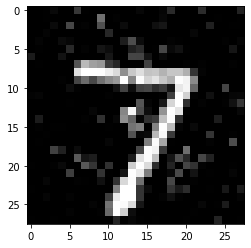

In [15]:
BEST = best + x_test[0]
plt.imshow(BEST.reshape(28,28),cmap='gray')
plt.show()

In [16]:
BEST_X

array([ 0.00000000e+00,  5.35446947e-06,  1.10066385e-04,  2.65087651e-02,
        4.63640851e-03,  8.33594749e-03,  1.30169376e-01,  0.00000000e+00,
        0.00000000e+00,  1.86479028e-01,  4.71923855e-03,  2.45130966e-07,
        0.00000000e+00,  1.29319669e-03,  3.23656286e-04,  0.00000000e+00,
        0.00000000e+00,  5.64201835e-02,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  5.69889149e-04,  1.51863814e-01,  1.22502850e-03,
        9.67149149e-08,  1.40191334e-02,  1.07860499e-02,  6.14505016e-03,
        0.00000000e+00,  0.00000000e+00,  2.13457171e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.37693103e-03,  4.48800554e-03,
        2.18240656e-03,  3.93665228e-01,  6.59929245e-06,  0.00000000e+00,
        1.62396368e-01,  6.26923415e-07,  4.55552430e-03,  0.00000000e+00,
        1.15290860e-04,  3.94743427e-04,  0.00000000e+00,  0.00000000e+00,
        7.59018538e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.99660678e-05,  

In [10]:
best=np.array([ 8.02704154e-04,  3.42688927e-03,  4.95504802e-03,  3.66173556e-02,
        0.00000000e+00,  0.00000000e+00,  2.17832798e-01,  4.44586916e-03,
        4.58726268e-04,  0.00000000e+00,  3.58520639e-03,  0.00000000e+00,
        8.52631340e-05,  0.00000000e+00,  3.03051974e-02,  1.23138957e-04,
        1.20183466e-03,  2.24841663e-02,  1.66661679e-01,  1.69119764e-03,
        0.00000000e+00,  0.00000000e+00,  1.78105790e-01,  0.00000000e+00,
        3.19994250e-05,  0.00000000e+00,  7.99942994e-04,  1.34884819e-01,
        0.00000000e+00,  6.44966334e-04,  7.16223400e-03,  6.75346409e-05,
        0.00000000e+00,  8.53631922e-04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  4.39004236e-01,  0.00000000e+00,  8.70617715e-03,
        0.00000000e+00,  0.00000000e+00,  3.21559213e-03,  0.00000000e+00,
        0.00000000e+00,  2.77806254e-02,  3.51216479e-04,  3.03383773e-04,
        0.00000000e+00,  0.00000000e+00,  2.10230997e-03,  3.96987159e-04,
        5.60873152e-03,  1.74631739e-05,  0.00000000e+00,  4.42708359e-03,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  4.17928603e-02,
        0.00000000e+00,  2.74298391e-01,  4.01740609e-03,  1.44262761e-02,
        3.59717966e-03,  3.13221687e-01,  3.86980486e-03,  4.65186680e-04,
        4.66559439e-02,  4.86739137e-05,  0.00000000e+00,  0.00000000e+00,
        6.00290212e-02,  8.60944461e-02,  1.95891140e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  2.30821836e-05,  1.29050486e-01,
        0.00000000e+00,  3.84694639e-03,  6.59758288e-03,  4.26326286e-03,
        0.00000000e+00,  0.00000000e+00,  1.89363591e-02,  0.00000000e+00,
        9.66695821e-04,  0.00000000e+00,  2.08551051e-04,  3.69499748e-04,
        0.00000000e+00,  0.00000000e+00,  1.54020379e-01,  3.96392143e-05,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.81514357e-06,  0.00000000e+00,  9.21054017e-04,  5.11281318e-04,
        0.00000000e+00,  3.05732844e-02,  4.29412893e-11,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  3.83349055e-04,  2.35517252e-03,
        0.00000000e+00,  1.92947994e-02,  0.00000000e+00,  3.41125657e-10,
        4.56755175e-02,  2.68617756e-02,  3.26949304e-06,  3.62239002e-04,
        1.80292883e-03,  0.00000000e+00,  1.84774139e-05,  0.00000000e+00,
        1.17048709e-01,  3.03072153e-01,  4.84787135e-02,  2.87745881e-04,
        0.00000000e+00,  0.00000000e+00,  1.32272960e-02,  4.09346003e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  6.86797117e-04,
        4.90007820e-07,  8.64737359e-03,  0.00000000e+00,  2.02526864e-02,
        6.31792468e-04,  4.95727108e-03,  0.00000000e+00,  0.00000000e+00,
        9.67984427e-10,  1.61637632e-01,  0.00000000e+00,  1.25189974e-02,
        0.00000000e+00,  8.30840104e-02,  4.85435473e-02,  0.00000000e+00,
        1.57652498e-06,  1.32759524e-01,  1.77379394e-01,  0.00000000e+00,
        5.26295348e-03,  2.75665346e-01,  3.34418799e-02,  6.91293164e-02,
        6.62448700e-03,  1.18904400e-03,  1.81517655e-03,  0.00000000e+00,
        3.17463662e-03,  0.00000000e+00,  8.47055813e-02,  1.96566717e-03,
        1.09076718e-01,  0.00000000e+00, -0.00000000e+00,  8.71039088e-04,
        7.24740479e-02,  1.17733268e-03,  0.00000000e+00,  9.44131664e-04,
        3.12551489e-05,  0.00000000e+00,  8.77691367e-02,  0.00000000e+00,
        0.00000000e+00,  2.71340272e-01,  2.67793047e-01,  8.18540383e-02,
        3.70352716e-03,  3.62414850e-02,  4.74258411e-04,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  3.99028291e-04,  8.19936977e-04,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  4.82471593e-03,  0.00000000e+00,  2.86181247e-04,
        1.61847205e-04,  9.34164092e-06,  0.00000000e+00, -1.17224387e-03,
        2.67031045e-03,  5.29947628e-03, -1.65034837e-03,  1.00723825e-02,
        2.95364774e-03, -0.00000000e+00,  4.96378099e-04,  2.59776969e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        7.92816485e-03,  0.00000000e+00,  9.18604041e-03,  0.00000000e+00,
        0.00000000e+00,  2.27696608e-03,  1.02954448e-02, -0.00000000e+00,
        0.00000000e+00,  1.48623531e-03,  0.00000000e+00,  2.60922048e-04,
        0.00000000e+00,  2.44309620e-03,  2.21025947e-03, -1.44270895e-03,
        0.00000000e+00, -4.21499708e-03, -6.67365672e-02, -9.28697201e-02,
       -2.17232206e-01,  8.60646295e-03,  9.39095793e-02, -8.44204095e-03,
        1.77595796e-03, -7.69160734e-02,  0.00000000e+00,  1.42346822e-04,
        2.27355470e-02,  0.00000000e+00,  1.82563314e-02,  0.00000000e+00,
        3.74227658e-04,  2.70253041e-04,  0.00000000e+00,  0.00000000e+00,
        7.29437882e-04,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        9.88924777e-03, -0.00000000e+00,  8.41686804e-03, -2.57170205e-02,
        0.00000000e+00, -3.39191015e-03, -9.70800520e-02, -2.92276525e-01,
        0.00000000e+00, -3.54273083e-01, -8.37222939e-03, -1.67042621e-01,
       -1.03073571e-01, -2.05229571e-01, -2.09757335e-01, -5.25740096e-03,
       -4.47127088e-02, -8.54569017e-03,  0.00000000e+00, -0.00000000e+00,
        1.84386952e-05,  0.00000000e+00,  0.00000000e+00,  2.30926430e-04,
        0.00000000e+00,  1.62559248e-04,  2.98070880e-03,  1.01414097e-04,
        4.34562727e-04,  4.80247895e-02,  8.21089870e-03,  2.16711374e-05,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.69842385e-07,
        0.00000000e+00, -5.70517827e-03, -1.03785339e-02,  1.42587333e-02,
       -9.07623465e-02, -3.93784055e-03,  0.00000000e+00, -2.04592994e-02,
       -3.54689479e-02, -9.32182380e-03,  0.00000000e+00,  3.26143026e-03,
        1.67388479e-03,  2.68852117e-01,  0.00000000e+00,  0.00000000e+00,
        1.32937263e-02,  2.17604533e-02,  1.71805194e-06,  0.00000000e+00,
        0.00000000e+00,  2.18219138e-05,  1.67379968e-05,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  9.54325918e-03,  2.42992335e-04,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  1.08957257e-02, -8.03306558e-02,  1.00314964e-03,
       -2.03276839e-03, -5.78053075e-02,  1.72354921e-03,  6.57765459e-02,
        3.44825992e-03,  7.35490330e-03,  2.58752298e-02,  3.07076510e-02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.51654069e-05,  4.26204345e-03,  0.00000000e+00,  5.73641971e-04,
        0.00000000e+00,  1.05405741e-03,  0.00000000e+00,  0.00000000e+00,
        1.07078551e-03, -0.00000000e+00,  3.32807827e-01,  2.32225360e-02,
        1.68971181e-05,  1.12646250e-02, -8.09443326e-02,  0.00000000e+00,
       -1.38260108e-01,  0.00000000e+00,  1.23126168e-02, -0.00000000e+00,
        0.00000000e+00,  8.00751925e-03,  6.74755802e-02,  2.17010475e-01,
        5.29326436e-06,  1.35933453e-04,  1.41979862e-09,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        2.71482818e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        5.24186377e-01,  9.67268222e-01,  3.01246837e-01,  5.24846760e-02,
        6.56995394e-07,  7.43833600e-02,  3.66963586e-03, -3.53232751e-02,
       -1.61731720e-01,  3.11068086e-03,  3.16480213e-04,  0.00000000e+00,
        0.00000000e+00,  9.19514733e-05,  0.00000000e+00,  3.20588437e-02,
        0.00000000e+00,  1.06051960e-01,  0.00000000e+00,  1.47730317e-04,
        3.84049649e-04,  0.00000000e+00,  2.66366276e-05,  7.99839826e-03,
        1.74914873e-03,  1.88776642e-01,  0.00000000e+00,  2.91715363e-02,
        5.60024264e-01,  3.94668154e-01,  2.22678189e-02,  1.93857345e-01,
        0.00000000e+00, -2.25618989e-01, -8.77367767e-03, -5.53893371e-02,
        1.45877709e-03,  6.82435729e-06,  0.00000000e+00,  4.02063507e-06,
        1.12046569e-01,  0.00000000e+00,  2.04583800e-03,  3.46259428e-03,
        0.00000000e+00,  7.90580548e-03,  0.00000000e+00,  4.58215825e-03,
        5.03302285e-03,  0.00000000e+00,  0.00000000e+00,  1.35933990e-03,
        0.00000000e+00,  0.00000000e+00,  7.43785319e-03,  7.84012352e-04,
        7.50248225e-06,  4.49468239e-01,  5.02816320e-01,  0.00000000e+00,
       -4.90455860e-03, -2.89537237e-03,  1.63432485e-03,  0.00000000e+00,
        3.86958128e-03,  3.59152117e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.34054972e-03,  0.00000000e+00,
        8.86715194e-05,  3.78363096e-04,  4.73166054e-03,  0.00000000e+00,
        2.11713032e-03,  3.40658346e-04,  2.96738836e-04,  1.11882251e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.06776283e-12,  3.26480135e-01,  2.54044450e-02,  2.39720857e-04,
       -8.20075095e-02,  0.00000000e+00,  4.33798139e-04,  6.35753592e-05,
        1.04786700e-03,  0.00000000e+00,  3.88792243e-03,  2.06514809e-01,
        2.92884164e-03,  0.00000000e+00,  1.11568869e-02,  0.00000000e+00,
        6.70476774e-05,  6.80175221e-03,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  4.31195379e-06,
        2.09191159e-03,  0.00000000e+00,  2.55006068e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  5.16749102e-03,
       -1.24961664e-02, -5.67495294e-02,  5.90426419e-03,  0.00000000e+00,
        0.00000000e+00,  1.97825724e-03,  1.01232453e-04,  1.31218728e-02,
        1.21464143e-06,  1.12191058e-05,  3.03817361e-01,  1.26242290e-04,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.61409796e-01,
        1.31269162e-01,  0.00000000e+00,  4.39236372e-02,  0.00000000e+00,
        1.27252906e-03,  9.87285474e-04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.38664053e-02,  1.56045753e-03,
        8.95150494e-03,  7.38046904e-03,  0.00000000e+00,  0.00000000e+00,
        4.27245194e-01,  0.00000000e+00,  1.29607758e-03,  2.17985028e-03,
        1.77446211e-05,  0.00000000e+00,  2.14257889e-03,  7.33651341e-04,
        0.00000000e+00,  0.00000000e+00,  1.29577452e-04,  1.82620688e-04,
        0.00000000e+00,  0.00000000e+00,  3.52298180e-01,  8.57652311e-02,
        1.16012386e-01,  3.63762844e-04,  0.00000000e+00,  0.00000000e+00,
        2.67291015e-04,  3.15970325e-02,  1.36118942e-02, -1.05974467e-02,
        9.71583423e-02,  0.00000000e+00,  8.34156098e-02,  3.15079190e-01,
        1.61976134e-01,  0.00000000e+00,  2.74675867e-01,  1.33120979e-01,
        1.05683440e-03, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        6.51128068e-03,  3.84151422e-03,  0.00000000e+00,  8.47301105e-03,
        3.58400664e-02,  0.00000000e+00,  7.93596517e-04,  3.45472221e-01,
        2.08077194e-01,  0.00000000e+00,  1.93645510e-01,  5.69780397e-04,
       -1.03313129e-02,  6.56427581e-03, -1.13785395e-03,  0.00000000e+00,
        3.35517989e-02,  0.00000000e+00,  1.37581057e-01,  1.20933366e-03,
        2.65928662e-01,  1.97155650e-01,  1.54852465e-02,  1.70304033e-06,
        0.00000000e+00,  0.00000000e+00,  6.35660491e-03,  0.00000000e+00,
        2.85769722e-05,  0.00000000e+00,  7.58429724e-05,  0.00000000e+00,
        0.00000000e+00,  2.42556234e-01,  4.32378324e-04,  0.00000000e+00,
        0.00000000e+00,  2.02662105e-01,  5.92241058e-03,  0.00000000e+00,
       -6.46851262e-02, -2.15094332e-03, -8.37761282e-02,  1.87774417e-01,
        0.00000000e+00,  0.00000000e+00,  3.24840475e-02,  2.89714543e-01,
        0.00000000e+00,  7.80886455e-02,  6.16704751e-04,  4.02050214e-03,
        2.18600398e-07,  1.90098195e-03,  2.16864225e-02,  1.80812716e-04,
        0.00000000e+00,  0.00000000e+00,  2.69111401e-02,  0.00000000e+00,
        0.00000000e+00,  3.28291245e-03,  9.51319586e-03,  6.92118602e-03,
        0.00000000e+00,  6.53647895e-02,  7.19748605e-05,  7.96496600e-02,
       -3.13877063e-02, -8.93461000e-03, -1.15696818e-02, -2.49240938e-03,
        0.00000000e+00,  0.00000000e+00,  2.79216418e-01,  0.00000000e+00,
        4.92138091e-05,  8.11932394e-03,  1.71151552e-05,  1.57877223e-04,
       -0.00000000e+00,  0.00000000e+00,  9.55442764e-04,  0.00000000e+00,
        4.97094429e-03,  0.00000000e+00,  1.76255102e-05,  4.23362548e-04,
        0.00000000e+00,  0.00000000e+00,  3.74641734e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -9.16902539e-03,
        3.71828479e-04,  2.67119822e-05,  1.48333832e-04,  4.33405195e-02,
        0.00000000e+00,  5.45872381e-04,  2.07805558e-01,  9.92435711e-02,
        1.70024817e-01,  1.06028978e-03,  3.38895396e-04,  5.06829777e-03,
        7.71733572e-05,  9.18239598e-02,  2.82014000e-04,  1.06116941e-01,
        0.00000000e+00,  0.00000000e+00,  2.29028212e-02,  1.12249673e-03,
        0.00000000e+00,  1.56000330e-02,  3.50458995e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  3.59824353e-03, -3.05165018e-02,
        1.98801781e-03,  3.75034320e-03,  0.00000000e+00,  1.88476371e-03,
        0.00000000e+00,  1.41798395e-02,  6.37844067e-02,  7.91201720e-03,
        0.00000000e+00,  4.25382334e-04,  6.50132084e-04,  3.87900873e-04,
        0.00000000e+00,  0.00000000e+00,  2.27492883e-03,  1.70323171e-02,
        4.60690361e-04,  1.45689276e-03,  0.00000000e+00,  2.55183754e-03,
        0.00000000e+00,  0.00000000e+00,  8.93810710e-07,  2.36764949e-04,
        1.93154209e-02,  4.48947704e-04, -2.16869334e-02, -3.14056752e-03,
       -1.53823056e-02,  0.00000000e+00, -6.31158607e-02,  0.00000000e+00,
        1.59475620e-04,  2.15513631e-05,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  2.08310245e-03,  3.00654428e-02,  0.00000000e+00,
        3.92981089e-03,  1.06533885e-01,  0.00000000e+00,  4.05496294e-05,
        0.00000000e+00,  0.00000000e+00,  2.67319755e-05,  0.00000000e+00,
        0.00000000e+00,  1.29683902e-02,  0.00000000e+00,  0.00000000e+00,
        2.41504910e-03,  1.16893920e-02, -5.97151878e-02, -1.87700611e-03,
       -3.55241621e-05, -1.71729521e-02,  3.97717605e-06,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  4.69018513e-03,  0.00000000e+00,  0.00000000e+00,
        1.79371479e-04,  5.62576351e-04,  0.00000000e+00,  0.00000000e+00,
        4.28894001e-03,  0.00000000e+00,  0.00000000e+00,  7.45882145e-03,
        1.03999973e-04,  0.00000000e+00,  0.00000000e+00,  3.48004067e-05,
        0.00000000e+00,  7.39194502e-04,  0.00000000e+00,  1.45430513e-01,
        1.56843199e-04,  2.70533301e-02,  6.73336443e-03,  0.00000000e+00,
        5.55204448e-03,  0.00000000e+00,  2.72352702e-06,  1.64873494e-03,
        5.90943711e-03,  2.69200564e-05,  3.13580852e-03,  0.00000000e+00,
        1.40516349e-01,  2.34860586e-05,  1.23091172e-03,  5.97359329e-03])

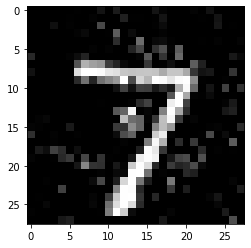

In [16]:
BEST = BEST_X + x_test[0]
plt.imshow(BEST.reshape(28,28),cmap='gray')
plt.show()

In [11]:
result=model.predict(best+x_test[0].reshape(1,784))
result[0]

array([1.7277554e-03, 1.3012809e-03, 8.4585741e-02, 4.7498396e-01,
       1.6625004e-04, 8.8276127e-03, 2.1934262e-05, 4.1101909e-01,
       1.0735265e-02, 6.6311397e-03], dtype=float32)

In [14]:
# test
count = 0
for i in range(784):
    if best[i] != 0:
        count+=1
print(count)

485


In [15]:
# test
count = 0
for i in range(784):
    if best[i] > 0.8:
        count+=1
print(count)

1


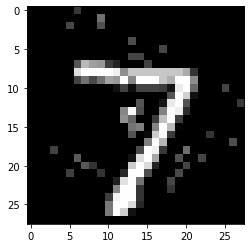

置信度： 0.7793143
[9.7315066e-04 8.2637573e-04 3.4473229e-02 1.7047375e-01 1.2569668e-04
 3.8995915e-03 1.1231668e-05 7.7931428e-01 4.2454870e-03 5.6572040e-03]
扰动程度： 4.974439211804689


In [16]:
#过滤（低强度）
import copy
x_f = copy.deepcopy(best)
for i in range(784):
    if abs(x_f[i]) < 0.2:
        x_f[i] = 0
f = x_f+x_test[0]
plt.imshow(f.reshape(28,28),cmap='gray')
plt.show()
result=model.predict(f.reshape(1,784))
print("置信度：", result[0][7])
print(result[0])
print("扰动程度：",Dis(x_f))

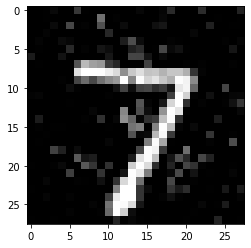

置信度： 0.617857
[1.7487891e-03 1.0965802e-03 8.0442332e-02 2.8074139e-01 1.6202116e-04
 5.9520868e-03 1.8165845e-05 6.1785698e-01 6.4293477e-03 5.5521866e-03]
扰动程度： 5.018550197841385


In [20]:
#过滤（高强度）
import copy
x_F = copy.deepcopy(best)
for i in range(784):
    if abs(x_F[i]) > 0.8:
        x_F[i] = 0
F = x_F+x_test[0]
plt.imshow(F.reshape(28,28),cmap='gray')
plt.show()
result=model.predict(F.reshape(1,784))
print("置信度：", result[0][7])
print(result[0])
print("扰动程度：",Dis(x_F))

迭代: 1
置信度： 0.77566266


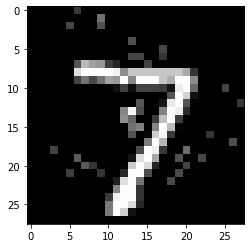

迭代: 2
置信度： 0.7642819


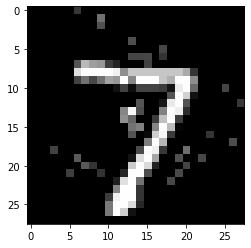

迭代: 3
置信度： 0.76208335


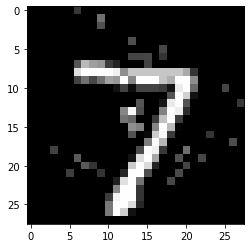

迭代: 4
置信度： 0.76049614


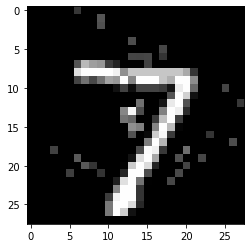

迭代: 5
置信度： 0.7579628


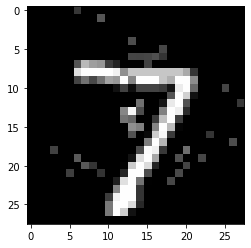

迭代: 6
置信度： 0.75785446


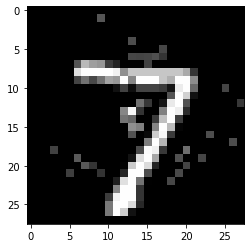

迭代: 7
置信度： 0.7562148


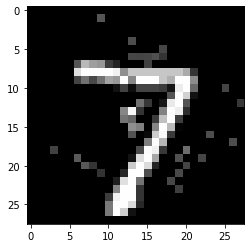

迭代: 8
置信度： 0.75584567


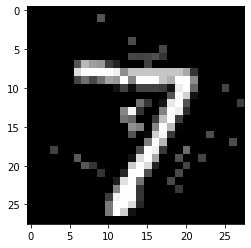

迭代: 9
置信度： 0.75193363


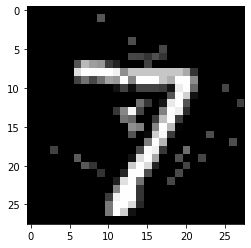

迭代: 10
置信度： 0.7515879


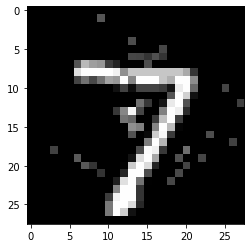

迭代: 11
置信度： 0.74643624


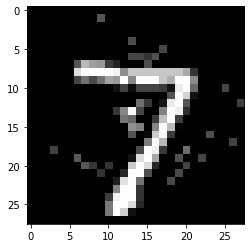

迭代: 12
置信度： 0.7409336


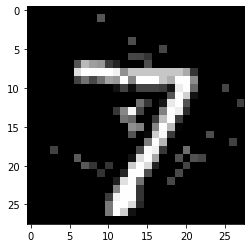

迭代: 13
置信度： 0.7408714


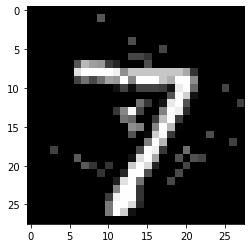

迭代: 14
置信度： 0.7402582


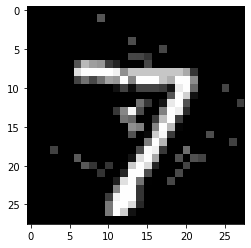

迭代: 15
置信度： 0.73792624


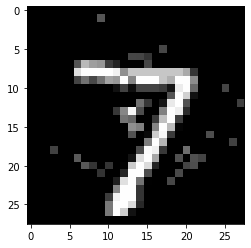

迭代: 16
置信度： 0.7331578


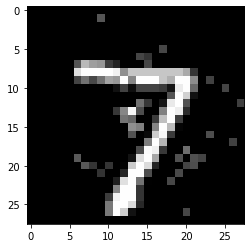

迭代: 17
置信度： 0.72942966


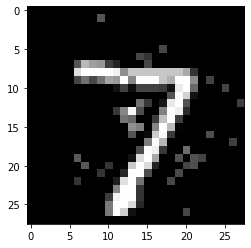

迭代: 18
置信度： 0.7293043


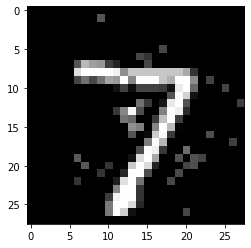

迭代: 19
置信度： 0.72842616


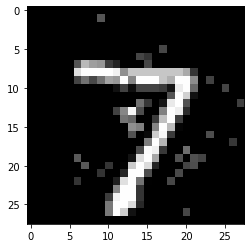

迭代: 20
置信度： 0.72683126


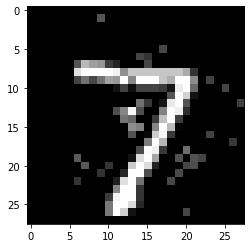

迭代: 21
置信度： 0.72605467


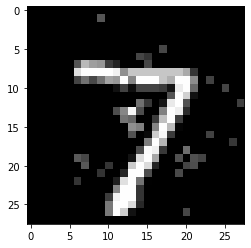

迭代: 22
置信度： 0.72429013


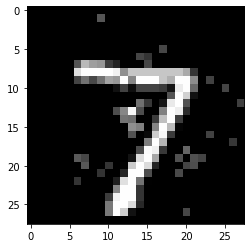

迭代: 23
置信度： 0.7234615


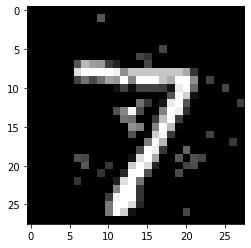

迭代: 24
置信度： 0.7152164


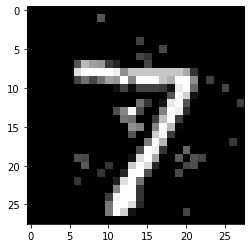

迭代: 25
置信度： 0.7151965


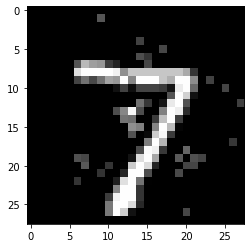

迭代失败


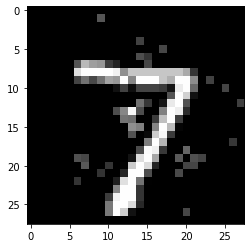

最终置信度： 0.7151965
最终扰动程度： 4.97443921180469
[1.1492642e-03 8.7629451e-04 3.3982661e-02 2.3108654e-01 1.4171211e-04
 5.4269200e-03 1.4119119e-05 7.1519649e-01 5.6285816e-03 6.4974395e-03]


In [21]:
# 改变坐标减小置信度（过滤0.2）
import copy
x_t = copy.deepcopy(x_f)
count = 0
for t in range(80):
    x_f1 = copy.deepcopy(x_t)
    con = 0
    while con < 1000:
        for i in range(784):
            if x_f1[i] > 0:
                x= random.randint(0,10000)/10000
                if x <= 0.1:
                    x_z = x_f1[i]
                    y = random.randint(0,783)
                    f_y = x_f1[y]+x_test[0][i]
                    f_i = x_f1[i]+x_test[0][y]
                    if  (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                        while (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                            y = random.randint(0,783)
                            f_y = x_f1[y]+x_test[0][i]
                            f_i = x_f1[i]+x_test[0][y]
                    x_f1[i] = x_f1[y]
                    x_f1[y] = x_z
        #print(Func(x_f1))
        con += 1
        if Func(x_f1) < Func(x_t):
            x_t = x_f1
            count += 1
            print("迭代:",count)
            print("置信度：",Func(x_t))
            f1 = x_t+x_test[0]
            plt.imshow(f1.reshape(28,28),cmap='gray')
            plt.show()
            break
        x_f1 = copy.deepcopy(x_t)
    if con == 1000:
        print("迭代失败")
        break
f = x_t+x_test[0]
plt.imshow(f.reshape(28,28),cmap='gray')
plt.show()
res=model.predict(f.reshape(1,784))
print("最终置信度：", res[0][7])
print("最终扰动程度：", Dis(x_t))
print(res[0])

迭代失败


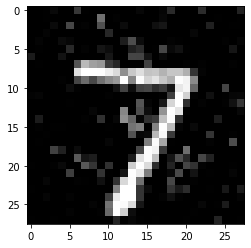

最终置信度： 0.617857
最终扰动程度： 5.018550197841385
[1.7487891e-03 1.0965802e-03 8.0442332e-02 2.8074139e-01 1.6202116e-04
 5.9520868e-03 1.8165845e-05 6.1785698e-01 6.4293477e-03 5.5521866e-03]


In [22]:
# 改变坐标减小置信度（过滤0.8）
import copy
x_t = copy.deepcopy(x_F)
count = 0
for t in range(80):
    x_f1 = copy.deepcopy(x_t)
    con = 0
    while con < 1000:
        for i in range(784):
            if x_f1[i] > 0:
                x= random.randint(0,10000)/10000
                if x <= 0.1:
                    x_z = x_f1[i]
                    y = random.randint(0,783)
                    f_y = x_f1[y]+x_test[0][i]
                    f_i = x_f1[i]+x_test[0][y]
                    if  (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                        while (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                            y = random.randint(0,783)
                            f_y = x_f1[y]+x_test[0][i]
                            f_i = x_f1[i]+x_test[0][y]
                    x_f1[i] = x_f1[y]
                    x_f1[y] = x_z
        #print(Func(x_f1))
        con += 1
        if Func(x_f1) < Func(x_t):
            x_t = x_f1
            count += 1
            print("迭代:",count)
            print("置信度：",Func(x_t))
            f1 = x_t+x_test[0]
            plt.imshow(f1.reshape(28,28),cmap='gray')
            plt.show()
            break
        x_f1 = copy.deepcopy(x_t)
    if con == 1000:
        print("迭代失败")
        break
f = x_t+x_test[0]
plt.imshow(f.reshape(28,28),cmap='gray')
plt.show()
res=model.predict(f.reshape(1,784))
print("最终置信度：", res[0][7])
print("最终扰动程度：", Dis(x_t))
print(res[0])

迭代失败


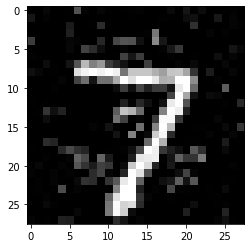

最终置信度： 0.39767227
最终扰动程度： 7.0038201815486
[3.7777259e-03 1.0443135e-03 1.1682559e-01 4.5660120e-01 1.5665211e-04
 1.2439688e-02 3.2627453e-05 3.9767227e-01 7.4698036e-03 3.9801179e-03]


In [11]:
# 改变坐标减小置信度
import copy
x_t = copy.deepcopy(BEST_X)
count = 0
for t in range(80):
    x_f1 = copy.deepcopy(x_t)
    con = 0
    while con < 1000:
        for i in range(784):
            if x_f1[i] > 0:
                x= random.randint(0,10000)/10000
                if x <= 0.1:
                    x_z = x_f1[i]
                    y = random.randint(0,783)
                    f_y = x_f1[y]+x_test[0][i]
                    f_i = x_f1[i]+x_test[0][y]
                    if  (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                        while (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                            y = random.randint(0,783)
                            f_y = x_f1[y]+x_test[0][i]
                            f_i = x_f1[i]+x_test[0][y]
                    x_f1[i] = x_f1[y]
                    x_f1[y] = x_z
        #print(Func(x_f1))
        con += 1
        if Func(x_f1) < Func(x_t):
            x_t = x_f1
            count += 1
            print("迭代:",count)
            print("置信度：",Func(x_t))
            f1 = x_t+x_test[0]
            plt.imshow(f1.reshape(28,28),cmap='gray')
            plt.show()
            break
        x_f1 = copy.deepcopy(x_t)
    if con == 1000:
        print("迭代失败")
        break
f = x_t+x_test[0]
plt.imshow(f.reshape(28,28),cmap='gray')
plt.show()
res=model.predict(f.reshape(1,784))
print("最终置信度：", res[0][7])
print("最终扰动程度：", Dis(x_t))
print(res[0])